In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import csv
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import datetime
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text

In [2]:
dataset = pd.read_csv('./data/train.csv')

In [3]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
def data_cleaning(sentence):
    #removing @ user
    clean_sentence = re.sub(r'@[A-Za-z0-9]+','',sentence)
    #removing http links
    clean_sentence = re.sub('https?://[A-Za-z0-9./]+','',clean_sentence)
    #removing # tag and numbers
    clean_sentence = re.sub("[^a-zA-Z]", " ", clean_sentence)
    return clean_sentence

In [5]:
dataset['clean_sentence'] = dataset['comment_text'].apply(lambda x: data_cleaning(x))

In [6]:
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_sentence
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D aww He matches this background colour I m s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,Hey man I m really not trying to edit war It...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,More I can t make any real suggestions on im...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,You sir are my hero Any chance you remember...


In [7]:
comment_len = [len(x) for x in dataset.comment_text.to_list()]

print("Total number of sentences: ",dataset.shape[0])
print("Average length of sentence: ",sum(comment_len)/len(comment_len))
print("Maximum sentence length: ",max(comment_len))
print("Min sentence length: ",min(comment_len))

Total number of sentences:  159571
Average length of sentence:  394.0732213246768
Maximum sentence length:  5000
Min sentence length:  6


In [8]:
labels = dataset.columns.to_list()[2:-1]
print("The sentences have been classified into:", labels)

The sentences have been classified into: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [9]:
freq_dict = {}
for i in labels:
    freq = np.sum(dataset[i])/dataset.shape[0]
    print("Label {} has a frequency of {}".format(i,freq))
    freq_dict[i] = freq

Label toxic has a frequency of 0.09584448302009764
Label severe_toxic has a frequency of 0.009995550569965721
Label obscene has a frequency of 0.052948217407925
Label threat has a frequency of 0.002995531769557125
Label insult has a frequency of 0.04936360616904074
Label identity_hate has a frequency of 0.00880485802558109


<AxesSubplot:>

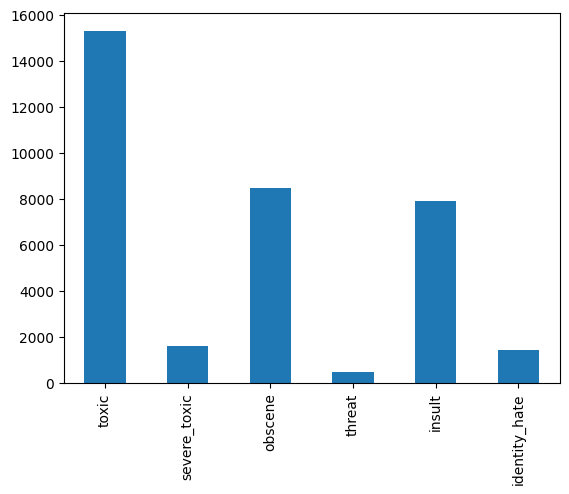

In [10]:
dataset[list(freq_dict.keys())].sum(axis=0).plot.bar()

In [11]:
pos_frequency = np.array(list(freq_dict.values()))
neg_frequency = 1-np.array(list(freq_dict.values()))

In [12]:
pos_weights = neg_frequency/dataset.shape[0]
neg_weights = pos_frequency/dataset.shape[0]

In [13]:
minority_df = dataset.loc[(dataset[list(freq_dict.keys())]!=0).any(axis=1)]
print("There are {} sentences with atleast 1 label which is {} % of the whole dataset".format(minority_df.shape[0],(minority_df.shape[0]/dataset.shape[0])*100))

There are 16225 sentences with atleast 1 label which is 10.167887648758233 % of the whole dataset


In [14]:
majority_df = dataset.loc[(dataset[list(freq_dict.keys())]==0).all(axis=1)]
print("There are {} sentences with atleast 0 label".format(majority_df.shape[0]))
print("This corresponds to {} % of whole data".format((majority_df.shape[0]/dataset.shape[0])*100))
majority_df = dataset[:minority_df.shape[0]]

There are 143346 sentences with atleast 0 label
This corresponds to 89.83211235124176 % of whole data


In [15]:
print("Taking equal number of label, total number of sentences is: ",(majority_df.shape[0] +  minority_df.shape[0]))

Taking equal number of label, total number of sentences is:  32450


In [16]:
df = pd.concat([minority_df,majority_df],axis=0)
df = df.sample(frac = 1)

In [17]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_sentence
5348,0e3a011026c3effd,Events happening in Dublin \n\nHi! As you tagg...,0,0,0,0,0,0,Events happening in Dublin Hi As you tagged...
896,02730f132825301d,FlexPay Tax Law \n\nJust a comment here. I'd ...,0,0,0,0,0,0,FlexPay Tax Law Just a comment here I d be...
7381,139e8ae85e94dade,""" and in any case the """"physical impacts"""" is ...",0,0,0,0,0,0,and in any case the physical impacts is ...
7092,12e92ce8374d1c24,"""\n \n\nYour request to be unblocked has been...",0,0,0,0,0,0,Your request to be unblocked has been gr...
3787,0a1e227d0bee3646,Yes sir i am. i have not reverted anything. ...,0,0,0,0,0,0,Yes sir i am i have not reverted anything ...


In [18]:
train_x = df.clean_sentence[:int(0.8*df.shape[0])]
train_y = np.array(df[list(freq_dict.keys())][:int(0.8*df.shape[0])].astype('float32'))

val_x = df.clean_sentence[int(0.8*df.shape[0]):]
val_y = np.array(df[list(freq_dict.keys())][int(0.8*df.shape[0]):].astype('float32'))


In [19]:
BERT_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

def build_model():
    bert = tf_hub.KerasLayer(BERT_MODEL)
    preprocess = tf_hub.KerasLayer(PREPROCESS_MODEL)
    text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text_input')
    input = preprocess(text_input)
    output = bert(input)
    pooled_output = output['pooled_output']

    x = tf.keras.layers.Dense(128,activation='relu')(pooled_output)
    #x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    #x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    pred = tf.keras.layers.Dense(6,activation='sigmoid')(x)

    model = tf.keras.Model(text_input,pred)

    return model

    


In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
model = build_model()#lstm_model(vocab_size, embedding_dims=embedding_dims,max_len=512,embedding_matrix= EMBEDDINGS_MATRIX)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['Accuracy',f1_m, precision_m, recall_m])
model.summary()

2023-04-27 16:12:18.855661: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['text_input[0][0]']             
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

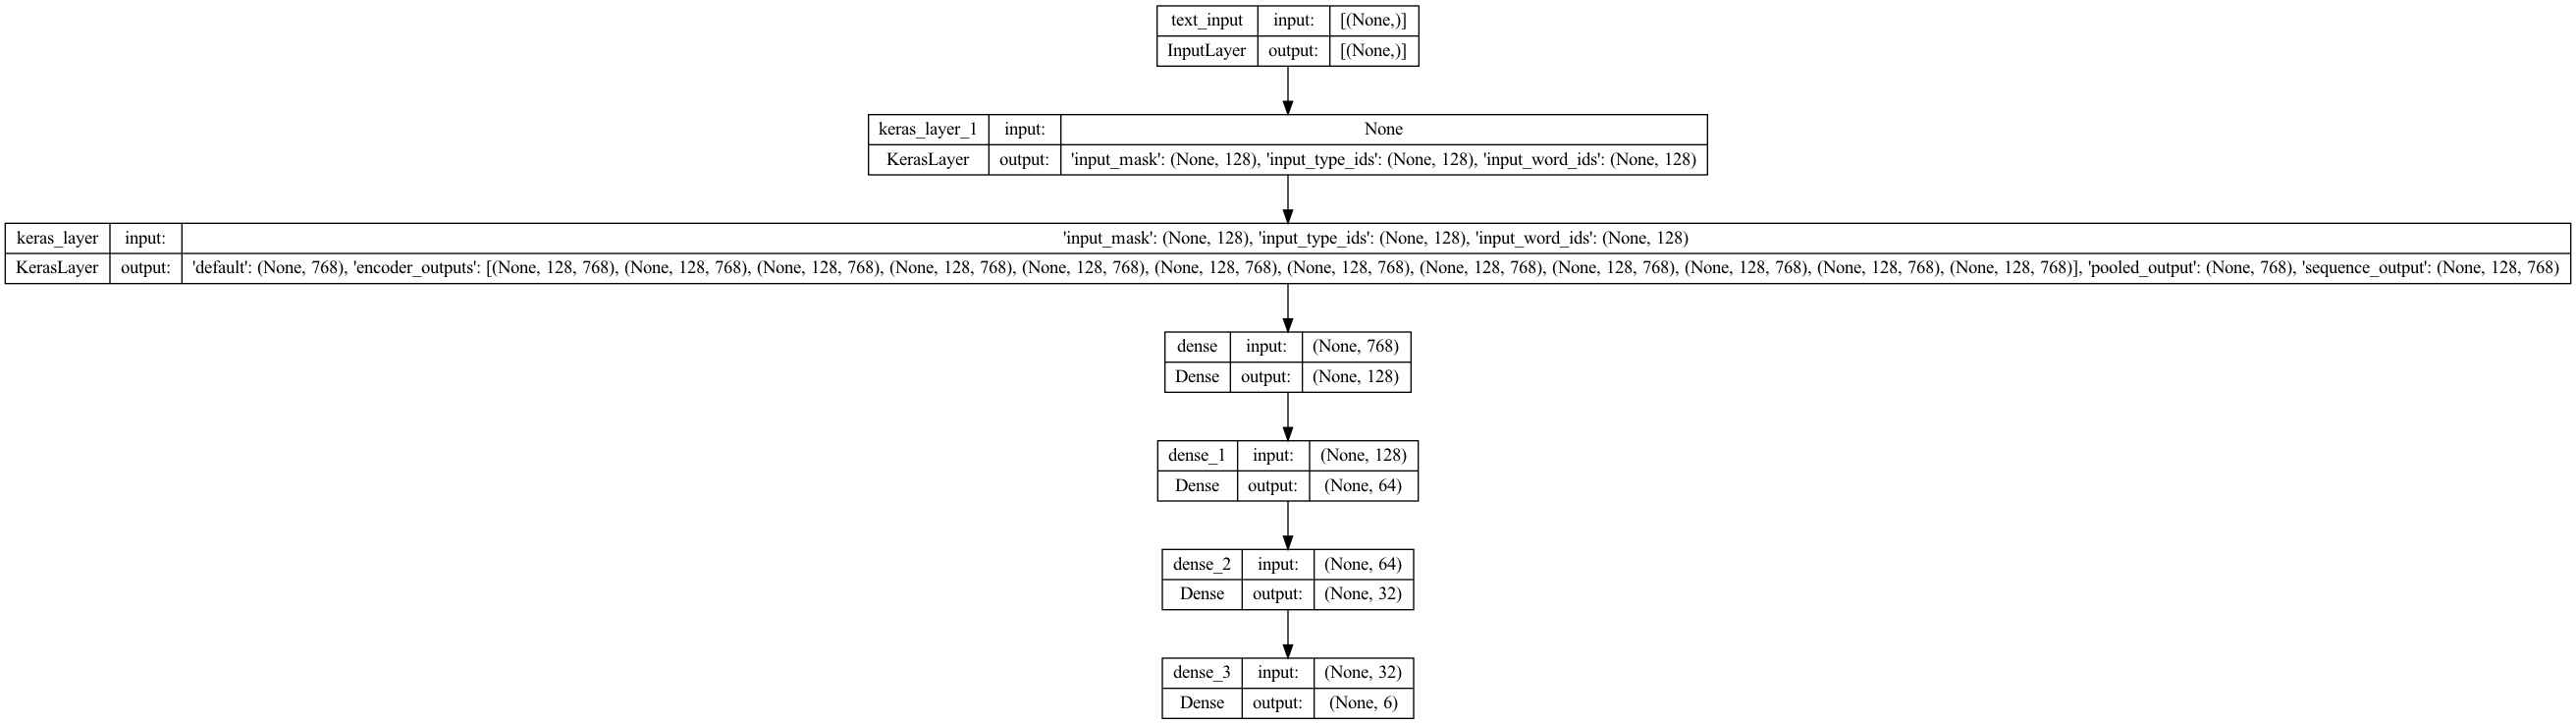

In [22]:
plot_model(model,to_file="model.png", show_shapes=True,show_layer_names=True)


In [23]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath="./model/",save_weights_only=False,monitor="val_f1_m", mode="max", save_best_only=True)

In [24]:
history = model.fit(train_x,train_y, 
                    epochs=5,
                    validation_data=(val_x,val_y),
                    callbacks=[tensorboard_callback,save_best],
                    batch_size=32)


Epoch 1/5
812/812 [==============================] - ETA: 0s - loss: 0.2860 - Accuracy: 0.9625 - f1_m: 0.6256 - precision_m: 0.7530 - recall_m: 0.5689

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


812/812 [==============================] - 2150s 3s/step - loss: 0.2860 - Accuracy: 0.9625 - f1_m: 0.6256 - precision_m: 0.7530 - recall_m: 0.5689 - val_loss: 0.2511 - val_Accuracy: 0.9698 - val_f1_m: 0.7140 - val_precision_m: 0.7857 - val_recall_m: 0.6613
Epoch 2/5
812/812 [==============================] - ETA: 0s - loss: 0.2495 - Accuracy: 0.9672 - f1_m: 0.7045 - precision_m: 0.7834 - recall_m: 0.6564

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


812/812 [==============================] - 2134s 3s/step - loss: 0.2495 - Accuracy: 0.9672 - f1_m: 0.7045 - precision_m: 0.7834 - recall_m: 0.6564 - val_loss: 0.2482 - val_Accuracy: 0.9696 - val_f1_m: 0.7331 - val_precision_m: 0.7540 - val_recall_m: 0.7206
Epoch 3/5
812/812 [==============================] - 2126s 3s/step - loss: 0.2437 - Accuracy: 0.9661 - f1_m: 0.7080 - precision_m: 0.7866 - recall_m: 0.6589 - val_loss: 0.2411 - val_Accuracy: 0.9693 - val_f1_m: 0.7280 - val_precision_m: 0.7894 - val_recall_m: 0.6823
Epoch 4/5
812/812 [==============================] - ETA: 0s - loss: 0.2397 - Accuracy: 0.9644 - f1_m: 0.7147 - precision_m: 0.7911 - recall_m: 0.6663

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


812/812 [==============================] - 2154s 3s/step - loss: 0.2397 - Accuracy: 0.9644 - f1_m: 0.7147 - precision_m: 0.7911 - recall_m: 0.6663 - val_loss: 0.2439 - val_Accuracy: 0.9696 - val_f1_m: 0.7409 - val_precision_m: 0.7573 - val_recall_m: 0.7332
Epoch 5/5
812/812 [==============================] - ETA: 0s - loss: 0.2375 - Accuracy: 0.9642 - f1_m: 0.7136 - precision_m: 0.7964 - recall_m: 0.6609

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


812/812 [==============================] - 2127s 3s/step - loss: 0.2375 - Accuracy: 0.9642 - f1_m: 0.7136 - precision_m: 0.7964 - recall_m: 0.6609 - val_loss: 0.2359 - val_Accuracy: 0.9690 - val_f1_m: 0.7421 - val_precision_m: 0.7613 - val_recall_m: 0.7314


In [27]:
def plot_graph(history):
    
    plt.plot(history.history['Accuracy'])
    plt.plot(history.history['val_Accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['f1_m'])
    plt.plot(history.history['val_f1_m'])
    plt.title('F1 score')
    plt.ylabel('F1 score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['precision_m'])
    plt.plot(history.history['val_precision_m'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['recall_m'])
    plt.plot(history.history['val_recall_m'])
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

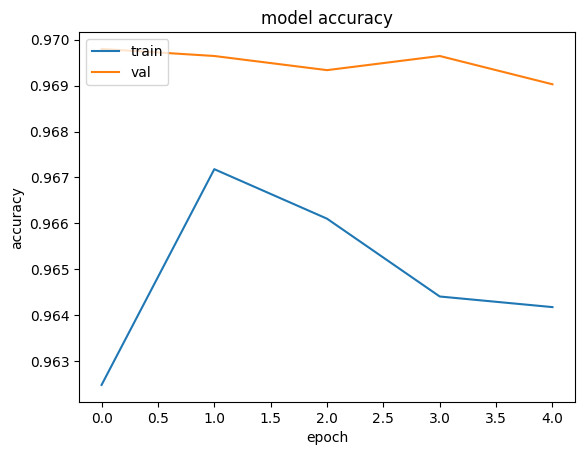

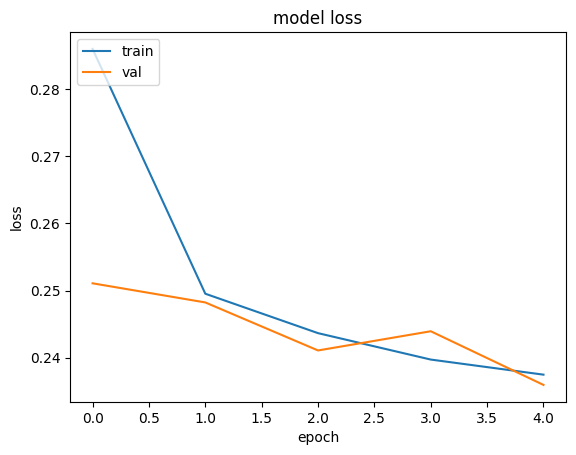

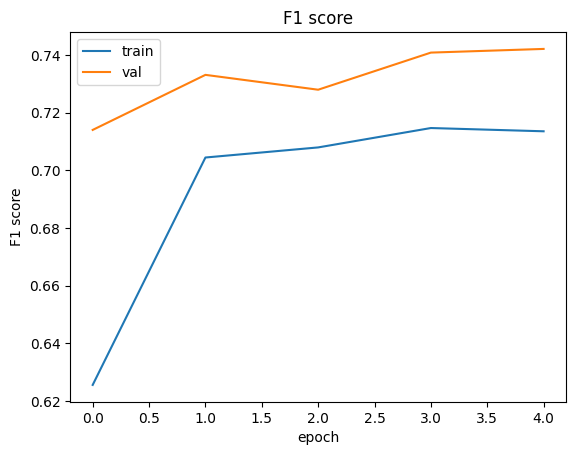

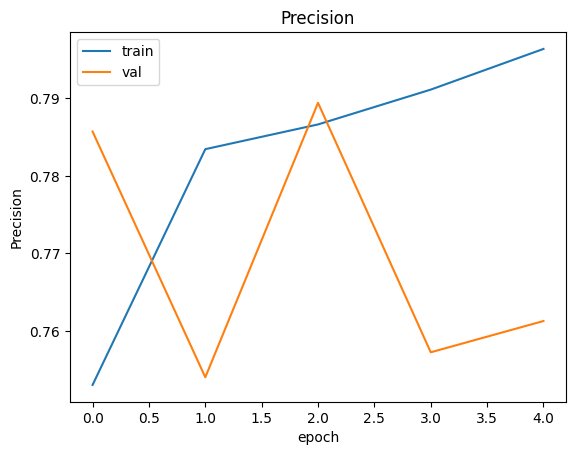

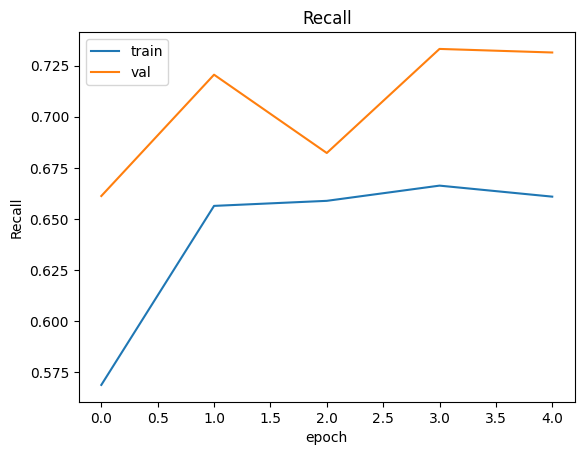

In [28]:
plot_graph(history)

In [29]:
print("libraries used in this code:")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


libraries used in this code:
tensorflow==2.9.2
csv==1.0
numpy==1.23.2
pandas==1.4.4
re==2.2.1
tensorflow_hub==0.12.0
tensorflow_text==2.9.0


In [30]:
with open("classes.txt", "w") as output:
    output.write(str(freq_dict.keys()))